# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 40#experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
x = 30 # No. of frames images
y = 120 # Width of the image
z = 120 # height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    resized_image = imresize(image,(y,z)) #crop the images and resize them. Note that the images are of 2 different shape 
                    resized_image = resized_image/25 #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = imresize(image,(y,z)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential()       
model.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, 120, 120, 3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#Softmax layer

model.add(Dense(5, activation='softmax'))

2022-12-13 07:39:01.349435: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-13 07:39:01.349496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
from tensorflow.keras.optimizers import Adam
optimiser = 'Adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 activation_1 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 40


/tmp/ipykernel_500/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


2022-12-13 07:39:12.427750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 6.7985 - categorical_accuracy: 0.3288Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-6.79850-0.32881-12.69998-0.19000.h5
17/17 [==============================] - 166s 10s/step - loss: 6.7985 - categorical_accuracy: 0.3288 - val_loss: 12.7000 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.9130 - categorical_accuracy: 0.4399
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-1.91299-0.43990-7.09366-0.25000.h5
17/17 [==============================] - 98s 6s/step - loss: 1.9130 - categorical_accuracy: 0.4399 - val_loss: 7.0937 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.5938 - categorical_accuracy: 0.5123
Epoch 00003: saving model to model_init_2022-12-1307_39_00.593560/model

### By using the base model without and droupout we are clearly overfitting the data. It clearly overfitts lets try some tweaking with Droupout

### categorical_accuracy: 0.9135
### val_categorical_accuracy: 0.7500

## Model_2 here removing batch normalisation and adding droupout and checking for any improvement

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model_2 = Sequential()       
model_2.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, 120, 120, 3),padding='same'))
#model.add(BatchNormalization())
model_2.add(Dropout(0.1))
model_2.add(Activation('relu'))

model_2.add(Conv3D(16, (3, 3, 3), padding='same'))
model_2.add(Activation('relu'))
#model.add(BatchNormalization())
model_2.add(Dropout(0.1))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(32, (2, 2, 2), padding='same'))
model_2.add(Activation('relu'))
#model.add(BatchNormalization())
model_2.add(Dropout(0.1))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(64, (2, 2, 2), padding='same'))
model_2.add(Activation('relu'))
#model.add(BatchNormalization())
model_2.add(Dropout(0.1))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(128, (2, 2, 2), padding='same'))
model_2.add(Activation('relu'))
#model.add(BatchNormalization()
model_2.add(Dropout(0.1))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_2.add(Flatten())

model_2.add(Dense(1000, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(500, activation='relu'))
model_2.add(Dropout(0.5))

#Softmax layer

model_2.add(Dense(5, activation='softmax'))

In [13]:
from tensorflow.keras.optimizers import Adam
optimiser = 'Adam' #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 dropout_2 (Dropout)         (None, 30, 120, 120, 8)   0         
                                                                 
 activation_5 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 activation_6 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 dropout_3 (Dropout)         (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)  

In [14]:
# Let us train and validate the model 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [15]:
# Let us fit the model

history_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /datasets/Project_data/train ; batch size = 40


/tmp/ipykernel_500/2073663117.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 2.3934 - categorical_accuracy: 0.2157Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-2.39345-0.21569-1.59812-0.34000.h5
17/17 [==============================] - 162s 10s/step - loss: 2.3934 - categorical_accuracy: 0.2157 - val_loss: 1.5981 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.5871 - categorical_accuracy: 0.2481
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-1.58707-0.24808-1.56016-0.21667.h5
17/17 [==============================] - 99s 6s/step - loss: 1.5871 - categorical_accuracy: 0.2481 - val_loss: 1.5602 - val_categorical_accuracy: 0.2167 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.4865 - categorical_accuracy: 0.2888
Epoch 00003: saving model to model_init_2022-12-1307_39_00.593

### The modelling with Droupout doesn't show the much improvement. Still overfitting the data

### categorical_accuracy: 0.9239
### val_categorical_accuracy: 0.8000


## Model_3 Here we will add both Batchnormalisation and Droupout and check if that helps.

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model_3 = Sequential()       
model_3.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, 120, 120, 3),padding='same'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.1))
model_3.add(Activation('relu'))

model_3.add(Conv3D(16, (3, 3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.1))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(32, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.1))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(64, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.1))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(128, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.1))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_3.add(Flatten())

model_3.add(Dense(1000, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(500, activation='relu'))
model_3.add(Dropout(0.5))

#Softmax layer

model_3.add(Dense(5, activation='softmax'))


In [17]:
from tensorflow.keras.optimizers import Adam
optimiser = 'Adam' #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 30, 120, 120, 8)   0         
                                                                 
 activation_10 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_11 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 activation_11 (Activation)  (None, 30, 120, 120, 16)  0         
                                                      

In [18]:
# Let us train and validate the model 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
history_3 = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 40


/tmp/ipykernel_500/2109916619.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_3 = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 8.5242 - categorical_accuracy: 0.2685Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-8.52417-0.26848-4.35064-0.24000.h5
17/17 [==============================] - 168s 10s/step - loss: 8.5242 - categorical_accuracy: 0.2685 - val_loss: 4.3506 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.7613 - categorical_accuracy: 0.4220
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-1.76130-0.42199-2.68561-0.26667.h5
17/17 [==============================] - 100s 6s/step - loss: 1.7613 - categorical_accuracy: 0.4220 - val_loss: 2.6856 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.3530 - categorical_accuracy: 0.4986
Epoch 00003: saving model to model_init_2022-12-1307_39_00.59

### By adding both batchnormalisation and droupout didn't heled it made the model worse 

### categorical_accuracy: 0.8166
### val_categorical_accuracy: 0.4000

## Architecture 2 - Conv2D + RNN

In [20]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

model_4 = Sequential()   
model_4.add(TimeDistributed(Conv2D(16, (3, 3),padding='same', activation='relu'),input_shape=(x,y,z,3)))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
    
model_4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten layer 

model_4.add(TimeDistributed(Flatten()))

model_4.add(LSTM(64))
model_4.add(Dropout(0.25))

# Dense layer 
model_4.add(Dense(64,activation='relu'))
model_4.add(Dropout(0.25))

# Softmax layer
model_4.add(Dense(5, activation='softmax'))

In [21]:
optimiser = 'Adam' #write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 dropout_2 (Dropout)         (None, 30, 120, 120, 8)   0         
                                                                 
 activation_5 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 activation_6 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 dropout_3 (Dropout)         (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)  

In [22]:
batch_size = 40
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
history_4 = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 40


/tmp/ipykernel_500/2157803987.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_4 = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1,


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.5530 - categorical_accuracy: 0.3092Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-1.55297-0.30920-1.62099-0.27000.h5
17/17 [==============================] - 169s 10s/step - loss: 1.5530 - categorical_accuracy: 0.3092 - val_loss: 1.6210 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.3649 - categorical_accuracy: 0.4348
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-1.36486-0.43478-1.72114-0.25000.h5
17/17 [==============================] - 99s 6s/step - loss: 1.3649 - categorical_accuracy: 0.4348 - val_loss: 1.7211 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.2901 - categorical_accuracy: 0.4850
Epoch 00003: saving model to model_init_2022-12-1307_39_00.593

### By using custom conv2D and LSTM also the model tends to overfitts.

### categorical_accuracy: 0.8028
### val_categorical_accuracy: 0.6667

## Here we are using GRU insted of LSTM and checking for improvement

In [24]:
# Let us experiment different x,y,z value in the CNNLSTM network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 120 # image width
z = 120 # image height

# Input all the images sequencial by building the layer with dropouts and batchnormalisation

model_5 = Sequential()   
model_5.add(TimeDistributed(Conv2D(8, (3, 3),padding='same', activation='relu'),input_shape=(x,y,z,3)))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten layer 

model_5.add(TimeDistributed(Flatten()))

model_5.add(GRU(64))
model_5.add(Dropout(0.25))

# Dense layer 
model_5.add(Dense(64,activation='relu'))
model_5.add(Dropout(0.25))

# Softmax layer
model_5.add(Dense(5, activation='softmax'))

# Adam optimiser

optimiser = 'Adam'  #write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 120, 120, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 120, 120, 8)  32        
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 60, 60, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 60, 60, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 60, 60, 16)  

In [25]:
# Let us train and validate the model 
batch_size = 40
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
history_5 = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 40


/tmp/ipykernel_500/532295929.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_5 = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1,


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.5430 - categorical_accuracy: 0.3454Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-1.54301-0.34540-1.93232-0.24000.h5
17/17 [==============================] - 168s 10s/step - loss: 1.5430 - categorical_accuracy: 0.3454 - val_loss: 1.9323 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.1385 - categorical_accuracy: 0.5217
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-1.13847-0.52174-2.35733-0.23333.h5
17/17 [==============================] - 99s 6s/step - loss: 1.1385 - categorical_accuracy: 0.5217 - val_loss: 2.3573 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.0680 - categorical_accuracy: 0.5504
Epoch 00003: saving model to model_init_2022-12-1307_39_00.593

### It is better in terms of train_accuracy and it tends to overfitts

### categorical_accuracy: 0.8824
### val_categorical_accuracy: 0.6667

## Augumentation

In [27]:
import cv2

In [28]:
# Let we do the generators and input the images as we see that our images have two different sizes. 
x = 30 # No. of frames images
y = 120 # Width of the image
z = 120 # height

def generatorWithAugmentation(source_path, folder_list, batch_size):
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Let us resize all the images 
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-20,20)],[0, 1, np.random.randint(-20,20)]]),(image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    resized_image = imresize(cropped,(y,z))
                    resized_image = resized_image/255
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches        
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-20,20)],[0, 1, np.random.randint(-20,20)]]),(image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    resized_image = imresize(cropped,(y,z))
                    resized_image = resized_image/255
                                        
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

## Using the first overfitted model with augumentation

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model_aug = Sequential()       
model_aug.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, 120, 120, 3),padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(Activation('relu'))

model_aug.add(Conv3D(16, (3, 3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_aug.add(Conv3D(32, (2, 2, 2), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_aug.add(Conv3D(64, (2, 2, 2), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_aug.add(Conv3D(128, (2, 2, 2), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_aug.add(Flatten())

model_aug.add(Dense(1000, activation='relu'))
model_aug.add(Dropout(0.5))

model_aug.add(Dense(500, activation='relu'))
model_aug.add(Dropout(0.5))

#Softmax layer

model_aug.add(Dense(5, activation='softmax'))

optimiser = 'Adam'
model_aug.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_aug.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_19 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 activation_16 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [31]:
# Let us see the Validate the Losses and put back the checkpoint

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [32]:
batch_size = 40

train_generator = generatorWithAugmentation(train_path, train_doc, batch_size)
val_generator = generatorWithAugmentation(val_path, val_doc, batch_size)

In [33]:
history_aug = model_aug.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_500/718867244.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_aug = model_aug.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1,


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 8.2789 - categorical_accuracy: 0.3183 
Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-8.27890-0.31825-2.18352-0.19000.h5
17/17 [==============================] - 196s 12s/step - loss: 8.2789 - categorical_accuracy: 0.3183 - val_loss: 2.1835 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 2.1166 - categorical_accuracy: 0.4373
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-2.11658-0.43734-3.05441-0.11667.h5
17/17 [==============================] - 121s 8s/step - loss: 2.1166 - categorical_accuracy: 0.4373 - val_loss: 3.0544 - val_categorical_accuracy: 0.1167 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.7424 - categorical_accuracy: 0.5232
Epoch 00003: saving model to model_init_2022-12-1307_39_00.593560/model-00003-1.74238-0.52316-2.55487-0.23333.h5

Epoch 

### It is not helping with the base model and using augumentation also hece we will shift to transfer learning

### categorical_accuracy: 0.7439
### val_categorical_accuracy: 0.4833

## Using of transfer learning wit LSTM

In [34]:
from keras.applications import mobilenet

In [35]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from keras import optimizers

In [36]:
x = 30 # No. of frames images
y = 120 # Width of the image
z = 120 # height

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


    

        
model_6 = Sequential()
model_6.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))
        
        
for layer in model_6.layers:
    layer.trainable = False
        
        
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Flatten()))

model_6.add(LSTM(64))
model_6.add(Dropout(0.25))
        
model_6.add(Dense(64,activation='relu'))
model_6.add(Dropout(0.25))
        
model_6.add(Dense(5, activation='softmax'))
        
optimiser = 'Adam'
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())



17235968/17225924 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                       

In [37]:
batch_size = 40

train_generator = generatorWithAugmentation(train_path, train_doc, batch_size)
val_generator = generatorWithAugmentation(val_path, val_doc, batch_size)

In [38]:
history = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_500/2698002504.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1,


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.5468 - categorical_accuracy: 0.3107 
Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-1.54680-0.31071-1.43610-0.43000.h5
17/17 [==============================] - 203s 12s/step - loss: 1.5468 - categorical_accuracy: 0.3107 - val_loss: 1.4361 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.2373 - categorical_accuracy: 0.5064
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-1.23728-0.50639-1.05813-0.66667.h5
17/17 [==============================] - 120s 8s/step - loss: 1.2373 - categorical_accuracy: 0.5064 - val_loss: 1.0581 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.0933 - categorical_accuracy: 0.5695
Epoch 00003: saving model to model_init_2022-12-1307_39_00.593560/model-00003-1.09335-0.56948-1.21902-0.45000.h5
17/17 [

### Model is performing Great in terms of train accuracy and not good  in test

### categorical_accuracy: 0.9619
### val_categorical_accuracy: 0.7500

## Visualising the results

In [39]:
import matplotlib.pyplot as plt

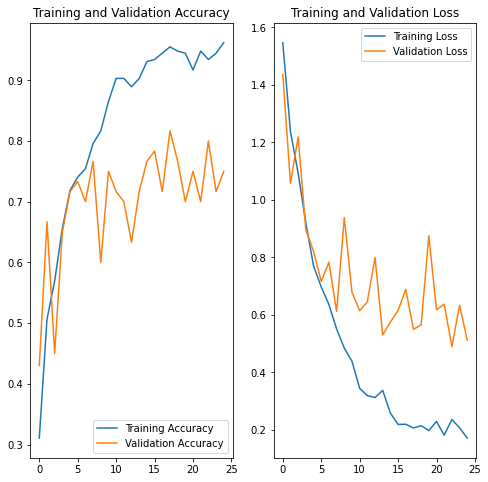

In [40]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Transfer learning with GRU

In [47]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


    

model_7 = Sequential()
model_7.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))
 
for layer in model_7.layers:
    layer.trainable = False
    
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7.add(TimeDistributed(Flatten()))

model_7.add(GRU(64))
model_7.add(Dropout(0.5))
        
model_7.add(Dense(64,activation='relu'))
model_7.add(Dropout(0.5))
        
model_7.add(Dense(5, activation='softmax'))
        
        
optimiser = 'Adam'
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_37 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

In [48]:
batch_size = 40
train_generator = generatorWithAugmentation(train_path, train_doc, batch_size)
val_generator = generatorWithAugmentation(val_path, val_doc, batch_size)

In [49]:
history2 = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_500/2382972693.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1,


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.8954 - categorical_accuracy: 0.2353 
Epoch 00001: saving model to model_init_2022-12-1307_39_00.593560/model-00001-1.89543-0.23529-1.43213-0.37000.h5
17/17 [==============================] - 201s 12s/step - loss: 1.8954 - categorical_accuracy: 0.2353 - val_loss: 1.4321 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.6619 - categorical_accuracy: 0.2992
Epoch 00002: saving model to model_init_2022-12-1307_39_00.593560/model-00002-1.66191-0.29923-1.40526-0.38333.h5
17/17 [==============================] - 120s 8s/step - loss: 1.6619 - categorical_accuracy: 0.2992 - val_loss: 1.4053 - val_categorical_accuracy: 0.3833 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.5089 - categorical_accuracy: 0.3488
Epoch 00003: saving model to model_init_2022-12-1307_39_00.593560/model-00003-1.50888-0.34877-1.26841-0.56667.h5
17/17 [

### Here we got the best train and test accuracy overall. Hence concluding the best model.

### categorical_accuracy: 0.8235
### val_categorical_accuracy: 0.7833

### Loss also less in terms both loss = 0.4977 and val_loss = 0.4977

### Visualizing the results

In [50]:
import matplotlib.pyplot as plt

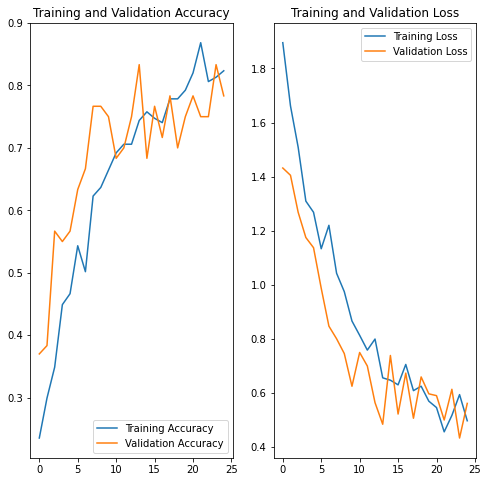

In [51]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()